<a href="https://colab.research.google.com/github/ChardyBalla/Chardy/blob/main/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cohort Analysis with Python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook, we aim to learn the following:
1. Perform simple data cleaning and exploration
2. Generate and visualize cohorts based on user retention

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In this exercise, we are given an [online retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) dataset containing transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.  
  
We are tasked to determine cohorts based on user retention and to provide insights and recommendations to improve customer loyalty.  

## Load and clean the data

Our data contains the following columns:

1. **InvoiceNo**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.
2. **StockCode**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
3. **Description**: Product (item) name. Nominal.
4. **Quantity**: The quantities of each product (item) per transaction. Numeric.
5. **InvoiceDate**: Invoice date and time. Numeric. The day and time when a transaction was generated.
6. **UnitPrice**: Unit price. Numeric. Product price per unit in sterling (Â£).
7. **CustomerID**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
8. **Country**: Country name. Nominal. The name of the country where a customer resides.

We are particularly interested in generating cohorts for our customers based on their first purchase date. With this in mind, we would consider the following for data cleaning:

1. Remove transaction if its `InvoiceNo` starts with the letter `'C'` (indicates a cancellation)
2. Remove transaction if the `CustomerID` is null/blank. The transaction will not be useful for our analysis since there is no corresponding customer.
3. Check for outliers (e.g. `Quantity` and `UnitPrice` should not be negative)

In [4]:
# We set Invoice and Customer ID as string types since they are the keys/ID for our dataset.
df = pd.read_excel('/content/drive/MyDrive/Refocus Module/Jupyter Notebook-20230501T012835Z-001/Jupyter Notebook/datasets/online_retail.xlsx',
                   dtype={'Invoice':str,
                          'InvoiceDate':'datetime64[ns]',
                          'Customer ID':str})
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


Let's first analyze the counts of transactions in our dataset

In [5]:
print('There are ', len(df), ' transactions in our dataset')
df.count()

There are  525461  transactions in our dataset


Invoice        525461
StockCode      525461
Description    522533
Quantity       525461
InvoiceDate    525461
Price          525461
Customer ID    417534
Country        525461
dtype: int64

We see that there are 525,461 transactions (rows) but some columns have lower counts. This indicates that there are null (empty) values for that column.

Let's count the `cancelled (starts with 'C')` invoices.

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [7]:
df['Invoice'].str.startswith('C')

0         False
1         False
2         False
3         False
4         False
          ...  
525456    False
525457    False
525458    False
525459    False
525460    False
Name: Invoice, Length: 525461, dtype: bool

In [8]:
~df['Invoice'].str.startswith('C')

0         True
1         True
2         True
3         True
4         True
          ... 
525456    True
525457    True
525458    True
525459    True
525460    True
Name: Invoice, Length: 525461, dtype: bool

In [9]:
df['Invoice'].str.startswith('C').sum()

10206

In [10]:
df = df[~df['Invoice'].str.startswith('C')]
df.count()

Invoice        515255
StockCode      515255
Description    512327
Quantity       515255
InvoiceDate    515255
Price          515255
Customer ID    407695
Country        515255
dtype: int64

We have 10,206 cancelled invoices in our dataset. We remove these transactions then proceed with removing the null/empty customer ID.

In [12]:
df['Customer ID'].isna().sum()

107560

In [13]:
df = df.dropna(subset=['Customer ID'])
df.count()

Invoice        407695
StockCode      407695
Description    407695
Quantity       407695
InvoiceDate    407695
Price          407695
Customer ID    407695
Country        407695
dtype: int64

We see that there are 107,560 transactions without a customer ID. This leaves us with 407,695 transactions.  
  
Next, we check our `Quantity` and `Price` for outliers.

In [14]:
df[['Quantity', 'Price']].describe()

,Quantity,Price
count,407695.000000,407695.000000
mean,13.586686,3.294188
std,96.842229,34.756655
min,1.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,19152.000000,10953.500000


Using the describe function, we see some descriptive statistics for our variables. Notice that there are also large max quantities and price compared to their 75th percentiles. We can also choose to remove them, but since we have mostly wholesale customers, there is a good chance that these quantities are correct.

In [15]:
df[df['Quantity']==df['Quantity'].max()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.1,13902,Denmark


In [16]:
df[df['Price']==df['Price'].max()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.5,12918,United Kingdom


The transaction with a very large quantity is a mug with a price of 0.1. This seems plausible an we can choose to retain this. Similarly, the transaction with the very large price was manually generated (based on the description) and is only 1 quantity. We can also retain this.

We now have a clean dataset ready for our exploratory and cohort analysis.

## Exploratory Analysis

When working with a new dataset, we usually start with an exploratory analysis to familiarize ourselves with the data and understand some patterns. In this exercise, let's look at the following metrics:

1. Count of Invoice and Customers
1. Number of Transactions per Customer
1. Monthly number of transactions

We choose this metrics since they would be more closely related to our end goal which is to group our customers into cohorts based on their first transactions.

Otherwise, it may also be interesting to see which stock codes have the most (bestsellers) and least (slow moving) transactions.

### Count of Invoice and Customers

In [17]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [20]:
df['Customer ID'].nunique()

4314

In [19]:
df['Invoice'].nunique()

19215

We see that we have 19,215 unique transactions across 4,314 customers. This means that each invoice may have multiple stock codes (items).

### Number of Transactions per Customer

In [21]:
# group by Customer ID 
# it may be possible to have multiple stock codes in a single invoice
# so we only count the unique Invoice.
df_customers = df.groupby('Customer ID')['Invoice'].nunique()
df_customers.head()

Customer ID
12346    11
12347     2
12348     1
12349     3
12351     1
Name: Invoice, dtype: int64

#### Who are the loyal customers (most transactions)?

Text(0.5, 0, 'Count of Transactions')

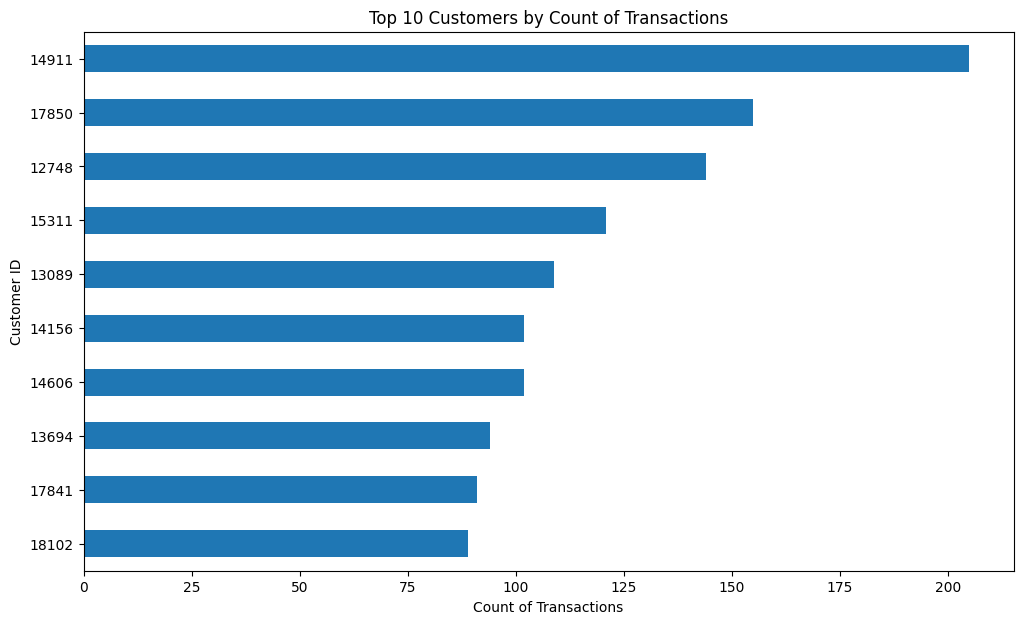

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.sort_values(ascending=True).tail(10).plot(kind='barh', ax=ax)
ax.set_title('Top 10 Customers by Count of Transactions')
ax.set_xlabel('Count of Transactions')

From the plot above, we see that our top 10 customers have at least 80 transactions over the range of our dataset (01/12/2009 to 09/12/2011). Our top customer has more than 200 transactions!

#### What is the distribution of our customer transactions?

Text(0, 0.5, 'Count of Customers')

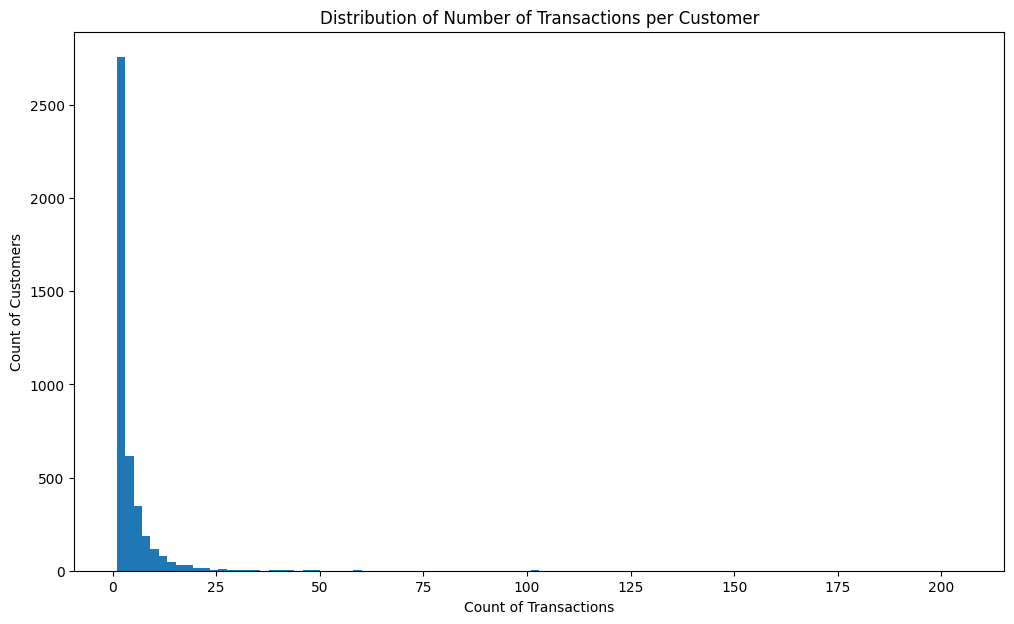

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
df_customers.plot(kind='hist', ax=ax, bins=100)
ax.set_title('Distribution of Number of Transactions per Customer')
ax.set_xlabel('Count of Transactions')
ax.set_ylabel('Count of Customers')

The histogram shows the distribution of our customer transactions. The leftmost bars indicate that we have a large number of customers (>2,500) with only a few transactions (least loyal). We also see some smaller bars in the right tail which tells us that we have a small number of customers with a large number of transactions (most loyal).

### Monthly Number of Transactions

In [24]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [25]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009,12


In [26]:
df_monthly = df.groupby(['Year', 'Month'])['Invoice'].nunique()
df_monthly

Year  Month
2009  12       1512
2010  1        1011
      2        1106
      3        1524
      4        1329
      5        1377
      6        1497
      7        1381
      8        1293
      9        1689
      10       2133
      11       2587
      12        776
Name: Invoice, dtype: int64

Text(0, 0.5, 'Count of Transactions')

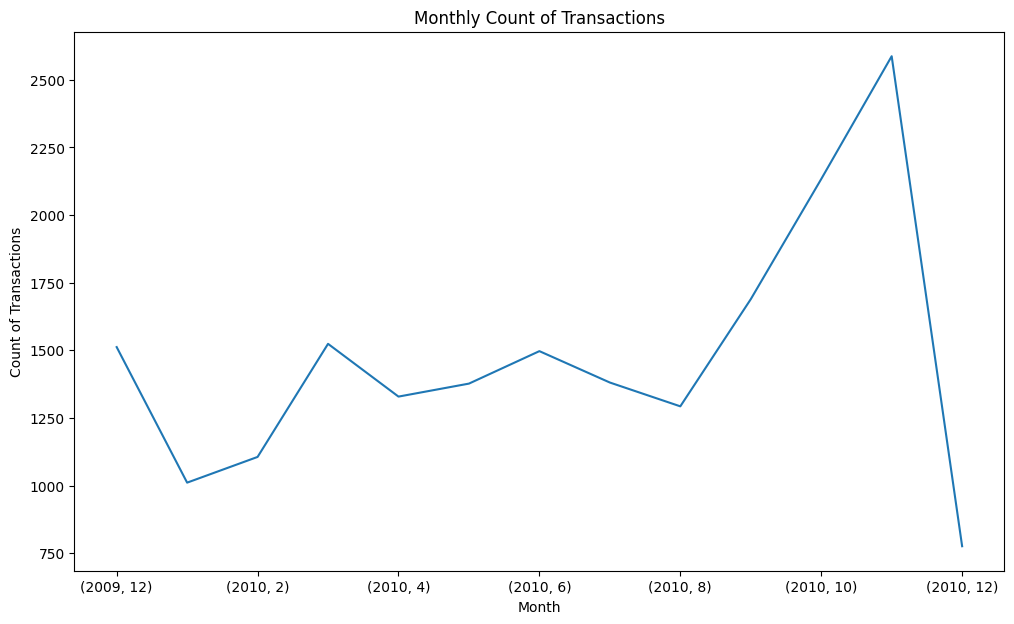

In [27]:
fig, ax = plt.subplots(figsize=(12, 7))
df_monthly.plot(ax=ax)
ax.set_title('Monthly Count of Transactions')
ax.set_xlabel('Month')
ax.set_ylabel('Count of Transactions')

We see a couple of interesting findings here.

1. Eventhough the data description states that the transactions ranges from  01/12/2009 to 09/12/2011, we see that we only have transactions up to December 2010. In this case, will continue our analysis with just the 1-year worth of transaction.

2. There is an overall increase in transactions (possible more revenue as well) from the past year. It also shows that transactions peaks towards the end of the year, possibly due to more customers purchasing christmas presents.

## Cohort Analysis

After doing a quick data exploration with our data, we can now proceed with the Cohort Analysis.  

In this case, we want to get insights based on user retention. To do this, we set the customer cohorts based on the month of their first transactions we then track their purchases throughout the year.

We first select only the relevant columns and drop duplicates (since it is possible to have multiple stock codes per invoice)

In [28]:
df_cohorts = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate
0,13085,489434,2009-12-01 07:45:00
8,13085,489435,2009-12-01 07:46:00
12,13078,489436,2009-12-01 09:06:00
31,15362,489437,2009-12-01 09:08:00
54,18102,489438,2009-12-01 09:24:00


Next, we create a cohort column based on the first transaction of each customer.

In [29]:
# Get the first transaction of each customer
# group by Customer ID and select the minimum InvoiceDate
# then convert the datetime values to year-month values
df_first_txn = df_cohorts.groupby('Customer ID')['InvoiceDate'].min().dt.to_period('M')
# rename to cohorts
df_first_txn.name = 'cohort'
df_first_txn.head(10)

Customer ID
12346    2009-12
12347    2010-10
12348    2010-09
12349    2010-04
12351    2010-11
12352    2010-11
12353    2010-10
12355    2010-05
12356    2010-10
12357    2010-11
Name: cohort, dtype: period[M]

In [30]:
# reset index to convert back to a dataframe
df_first_txn = df_first_txn.reset_index()
df_first_txn.head(10)

,Customer ID,cohort
0,12346,2009-12
1,12347,2010-10
2,12348,2010-09
3,12349,2010-04
4,12351,2010-11
5,12352,2010-11
6,12353,2010-10
7,12355,2010-05
8,12356,2010-10
9,12357,2010-11


In [31]:
df_cohorts.head()

,Customer ID,Invoice,InvoiceDate
0,13085,489434,2009-12-01 07:45:00
8,13085,489435,2009-12-01 07:46:00
12,13078,489436,2009-12-01 09:06:00
31,15362,489437,2009-12-01 09:08:00
54,18102,489438,2009-12-01 09:24:00


In [32]:
# Merge the created dataframe with our original table
df_cohorts = df_cohorts.merge(df_first_txn, how='left', on='Customer ID')
df_cohorts.tail(10)

,Customer ID,Invoice,InvoiceDate,cohort
19240,15555,538156,2010-12-09 16:53:00,2009-12
19241,17576,538157,2010-12-09 16:57:00,2009-12
19242,17841,538163,2010-12-09 17:27:00,2009-12
19243,14031,538165,2010-12-09 17:34:00,2009-12
19244,17965,538166,2010-12-09 18:09:00,2009-12
19245,14713,538167,2010-12-09 18:58:00,2009-12
19246,14702,538168,2010-12-09 19:23:00,2009-12
19247,13230,538169,2010-12-09 19:28:00,2010-03
19248,13969,538170,2010-12-09 19:32:00,2010-03
19249,17530,538171,2010-12-09 20:01:00,2009-12


In the sample table above, we see that even if the InvoiceDate is on December 2010, some customers have their first transaction as far back as on December 2009.  

Next, we convert the InvoiceDate column to a year-month variable (txn_month)

In [33]:
df_cohorts['txn_month'] = df_cohorts['InvoiceDate'].dt.to_period('M')
df_cohorts.head(10)

,Customer ID,Invoice,InvoiceDate,cohort,txn_month
0,13085,489434,2009-12-01 07:45:00,2009-12,2009-12
1,13085,489435,2009-12-01 07:46:00,2009-12,2009-12
2,13078,489436,2009-12-01 09:06:00,2009-12,2009-12
3,15362,489437,2009-12-01 09:08:00,2009-12,2009-12
4,18102,489438,2009-12-01 09:24:00,2009-12,2009-12
5,12682,489439,2009-12-01 09:28:00,2009-12,2009-12
6,18087,489440,2009-12-01 09:43:00,2009-12,2009-12
7,18087,489441,2009-12-01 09:44:00,2009-12,2009-12
8,13635,489442,2009-12-01 09:46:00,2009-12,2009-12
9,14110,489443,2009-12-01 09:50:00,2009-12,2009-12


We now have a `cohort` column corresponding to the year-month of a customers' first transaction and a `txn_month` column corresponding to the actual year-month of the transaction.

We can now view our cohorts. We group the table by `cohort` and `txn_month` and get the counts of unique customer for each cohort.

In [34]:
df_cohorts = df_cohorts.groupby(['cohort', 'txn_month'])['Customer ID'].nunique()
df_cohorts.name = 'num_customers'
df_cohorts = df_cohorts.reset_index()
df_cohorts.head(10)

,cohort,txn_month,num_customers
0,2009-12,2009-12,955
1,2009-12,2010-01,337
2,2009-12,2010-02,319
3,2009-12,2010-03,406
4,2009-12,2010-04,363
5,2009-12,2010-05,343
6,2009-12,2010-06,360
7,2009-12,2010-07,327
8,2009-12,2010-08,321
9,2009-12,2010-09,346


The resulting table shows the number of customers who had their first purchase in their cohorts and the customers for each succeeding month. For example, their are 346 customers who had their first purchase on December 2009 but they also had a transaction on September 2010.

Let's add a period number column which corresponds to the number of months since their first purchase

In [35]:
# subtract cohort from txn_month, this will result in a MonthEnd pandas datatype
# to get the value as integer, we use the pandas apply function
df_cohorts['period_number'] = (df_cohorts.txn_month - df_cohorts.cohort).apply(lambda x: x.n)
df_cohorts.head(10)

,cohort,txn_month,num_customers,period_number
0,2009-12,2009-12,955,0
1,2009-12,2010-01,337,1
2,2009-12,2010-02,319,2
3,2009-12,2010-03,406,3
4,2009-12,2010-04,363,4
5,2009-12,2010-05,343,5
6,2009-12,2010-06,360,6
7,2009-12,2010-07,327,7
8,2009-12,2010-08,321,8
9,2009-12,2010-09,346,9


Next, we pivot our table to get our cohorts as the index and the period number as the columns. This makes the data easier to visualize and interpret.

In [36]:
df_pivot = df_cohorts.pivot_table(index='cohort', columns='period_number', values='num_customers')
df_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,237.0
2010-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,38.0,NaN
2010-02,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,27.0,NaN,NaN
2010-03,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,35.0,NaN,NaN,NaN
2010-04,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,20.0,NaN,NaN,NaN,NaN
2010-05,254.0,40.0,43.0,44.0,45.0,65.0,54.0,20.0,NaN,NaN,NaN,NaN,NaN
2010-06,270.0,47.0,51.0,55.0,62.0,77.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,186.0,29.0,34.0,55.0,54.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,162.0,33.0,48.0,52.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lastly, we can convert the counts to percentages (% retention) by dividing the values of each row by the the original cohort size (period=0)

In [37]:
# get the original cohort size
df_orig_cohorts = df_pivot[0]
df_orig_cohorts

cohort
2009-12    955.0
2010-01    383.0
2010-02    376.0
2010-03    443.0
2010-04    294.0
2010-05    254.0
2010-06    270.0
2010-07    186.0
2010-08    162.0
2010-09    243.0
2010-10    377.0
2010-11    325.0
2010-12     46.0
Freq: M, Name: 0, dtype: float64

In [38]:
# divide by original cohort size
df_pivot = df_pivot.divide(df_orig_cohorts, axis=0)
df_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,0.421990,0.495288,0.248168
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,0.302872,0.099217,NaN
2010-02,1.0,0.236702,0.223404,0.289894,0.244681,0.199468,0.191489,0.284574,0.252660,0.273936,0.071809,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.068027,NaN,NaN,NaN,NaN
2010-05,1.0,0.157480,0.169291,0.173228,0.177165,0.255906,0.212598,0.078740,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.174074,0.188889,0.203704,0.229630,0.285185,0.066667,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.155914,0.182796,0.295699,0.290323,0.102151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.203704,0.296296,0.320988,0.117284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have our retention matrix. The row index shows the cohort membership and the columns represent the number of months since their first transaction.

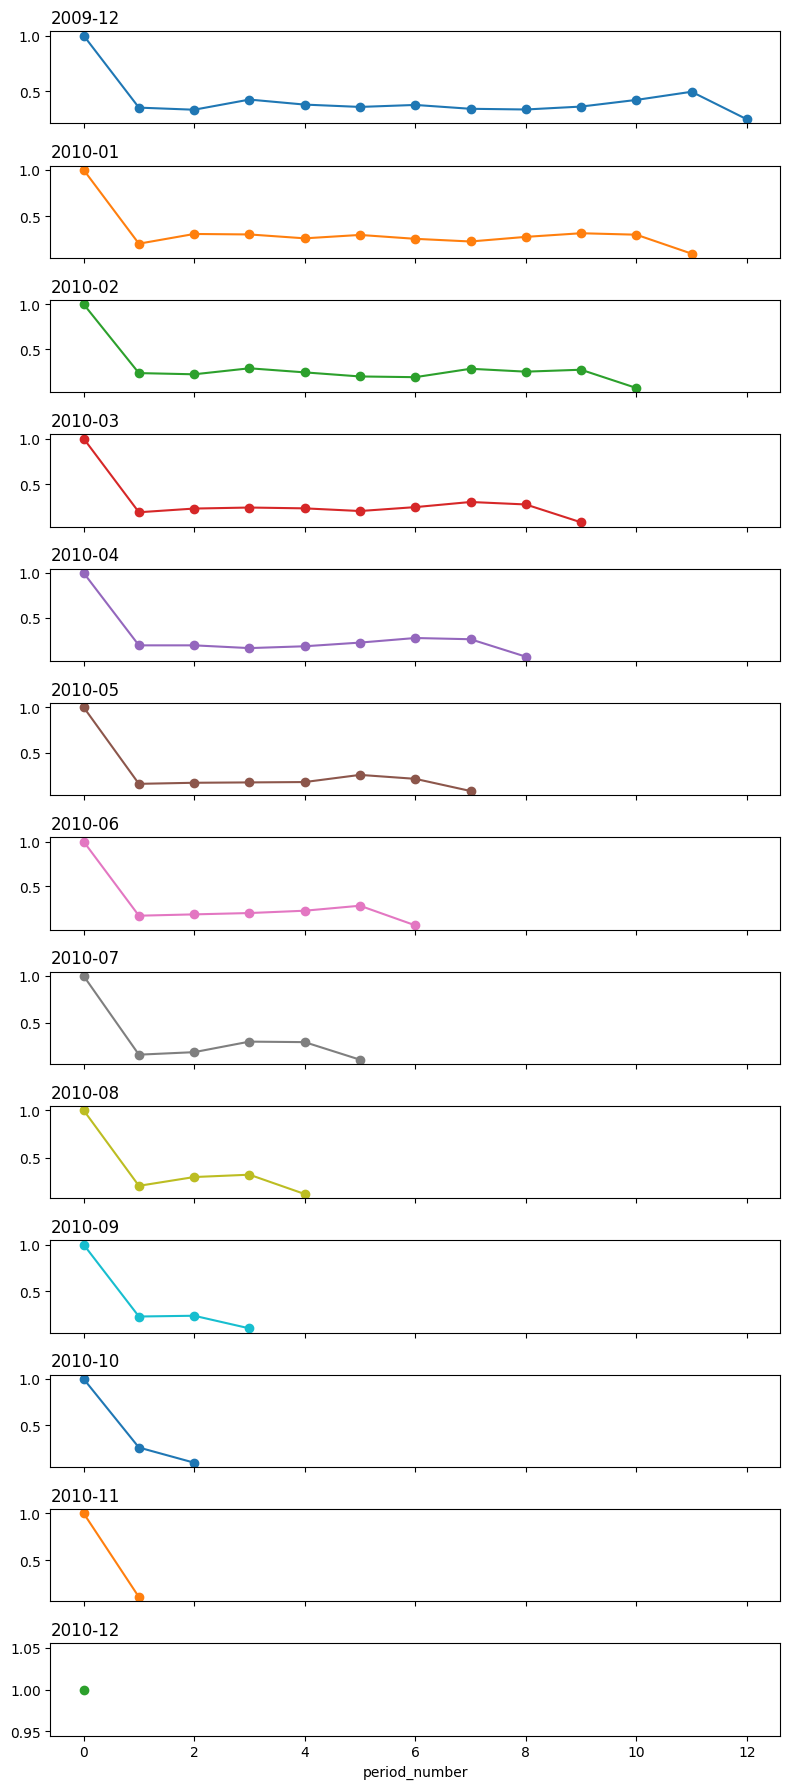

In [39]:
# plot all cohorts in a line
fig, ax = plt.subplots(13, 1, figsize=(8, 18), sharex=True)

df_pivot.T.plot(ax=ax, subplots=True, legend=False, marker='o');

for i, cohort in enumerate(df_pivot.index):
    ax[i].set_title(cohort, loc='left')

fig.tight_layout()


To make it easier to digest, we can plot it using a [heatmap](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).

##### Shortcut: Plot using a helper function. Just copy the function and run with the required inputs.

In [42]:
import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for _, spine in ax.spines.items():
      spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

##### We can input our retention matrix and the required labels. We can also set our title and axis labels.

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:374: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


Text(0.5, 0, 'Period')

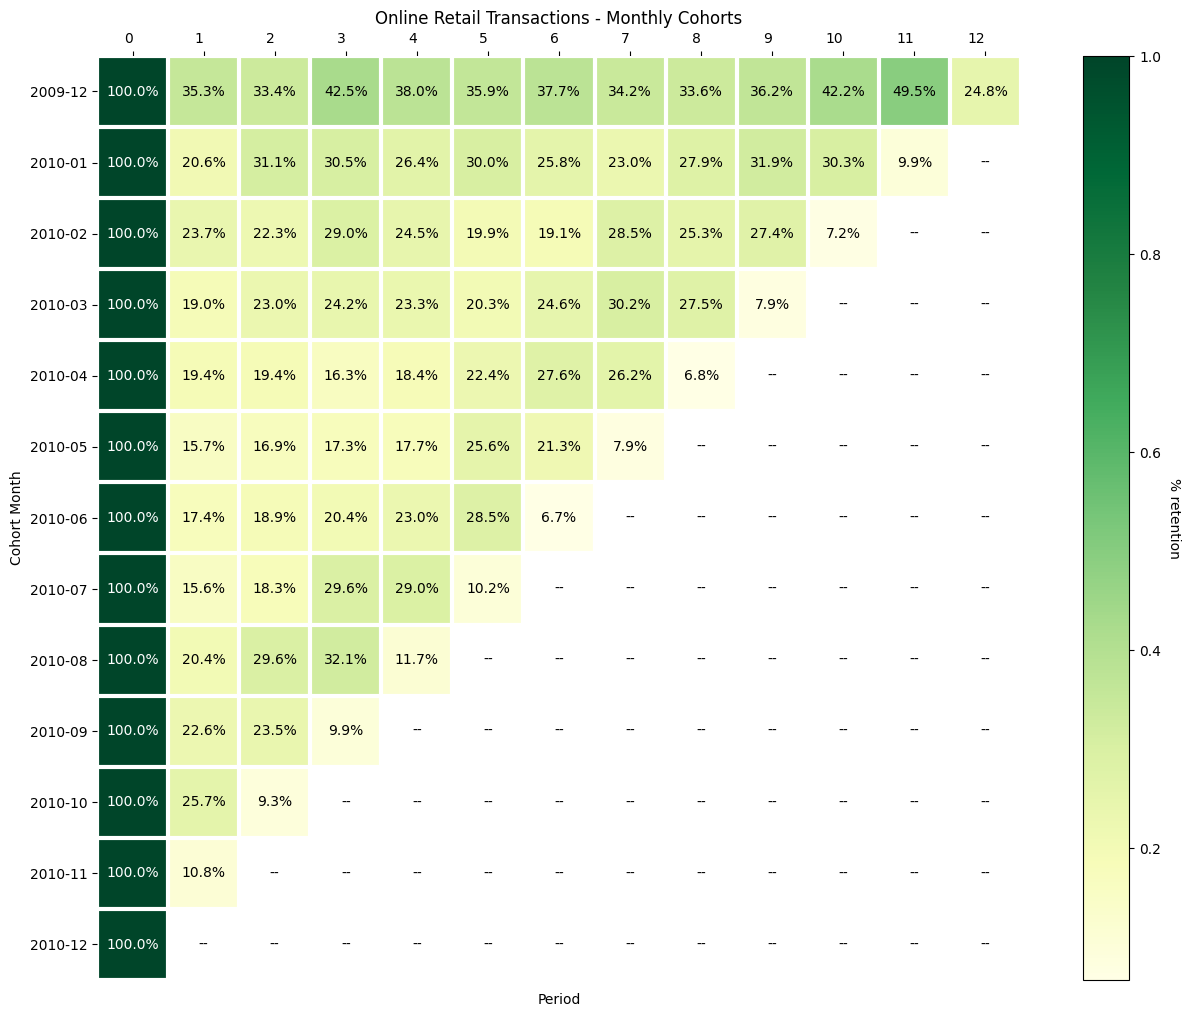

In [41]:
fig, ax = plt.subplots(figsize=(16,12))

im, cbar = heatmap(df_pivot.values, df_pivot.index, df_pivot.columns, ax=ax,
                   cmap="YlGn", cbarlabel="% retention")
texts = annotate_heatmap(im, valfmt="{x:.1%}")

ax.set_title('Online Retail Transactions - Monthly Cohorts')
ax.set_ylabel('Cohort Month')
ax.set_xlabel('Period')

## Conclusion and Recommendation

Using pandas and matplotlib functions, we were able to segment our customers and visualize their cohorts with a heatmap. With this chart, we can see the cohorts (based on customers' first transaction month) and their activity for the succeeding months.

We generated 13 cohorts (December 2009 - December 2010). The darker green cells shows the periods with higher activity. For example, observe the customers in the 2009-12 cohort, there was an increase in activity in the 11th period - 49.5% (approximately November 2010). This means that customers in this cohort seemed to be more active during the end-of-year holidays (seasonal customers).

Also, notice that there was lower retention rate for cohorts in the middle of the year (2010-03 - 2010-07). This may indicate that we mostly acquired one-time customers during this months. We may want to focus our marketing campaigns on retention rather than on customer acquisitions.

This concludes our cohort analysis with python. Recall that by cleaning and understanding our data with exploratory analysis, we can get the knowledge on which variables are important for us. By properly preparing and visualizing our data, we can immediately generate insights and recommendations for our stakeholders.